In [325]:
# Necessary libraries...
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanAbsoluteError, Huber, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

from tabulate import tabulate
import scipy.stats as stats

#### **Data Loading and preparation**


In [326]:
dataset = pd.read_csv("./train.csv")
dataset.sample(5)

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
24,25,651106,779208,4,53137,3,8,8,191,109,121,518845.0
279,280,620214,899611,7,124062,4,5,8,186,85,125,257565.5
799,800,510669,833987,3,96784,3,2,14,145,93,124,285487.0
375,376,689935,856093,5,60213,4,8,13,165,88,79,547746.0
783,784,573920,793513,6,129656,5,9,13,186,76,138,192576.0


In [327]:
# Check for null values and duplicated values.
print(f"Number of null values: {dataset.isna().sum().any()}")
print(f"Number of duplicated values: {dataset.duplicated().sum().any()}")


Number of null values: False
Number of duplicated values: False


In [328]:
# Check for statistical descriptions.
dataset.describe()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
count,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.00000
mean,500.500000,601648.286000,799131.3970,4.561000,100274.430000,2.988000,5.592000,11.625000,166.89300,84.54600,103.423000,308520.24250
std,288.819436,58407.246204,57028.9502,1.719079,29150.463233,1.402791,2.824449,2.230549,19.28838,20.51694,21.058716,126073.25915
min,1.000000,500265.000000,700018.0000,2.000000,50324.000000,1.000000,1.000000,8.000000,135.00000,50.00000,68.000000,28226.50000
25%,250.750000,548860.500000,750997.7500,3.000000,74367.500000,2.000000,3.000000,10.000000,150.00000,67.00000,85.000000,206871.75000
50%,500.500000,601568.000000,798168.0000,5.000000,100139.500000,3.000000,6.000000,12.000000,166.00000,84.00000,104.000000,306717.75000
75%,750.250000,652267.250000,847563.2500,6.000000,125048.000000,4.000000,8.000000,13.000000,184.00000,102.00000,121.000000,414260.87500
max,1000.000000,699859.000000,899797.0000,7.000000,149902.000000,5.000000,10.000000,15.000000,200.00000,120.00000,140.000000,584267.50000


In [329]:
dataset.columns

Index(['v.id', 'on road old', 'on road now', 'years', 'km', 'rating',
       'condition', 'economy', 'top speed', 'hp', 'torque', 'current price'],
      dtype='object')

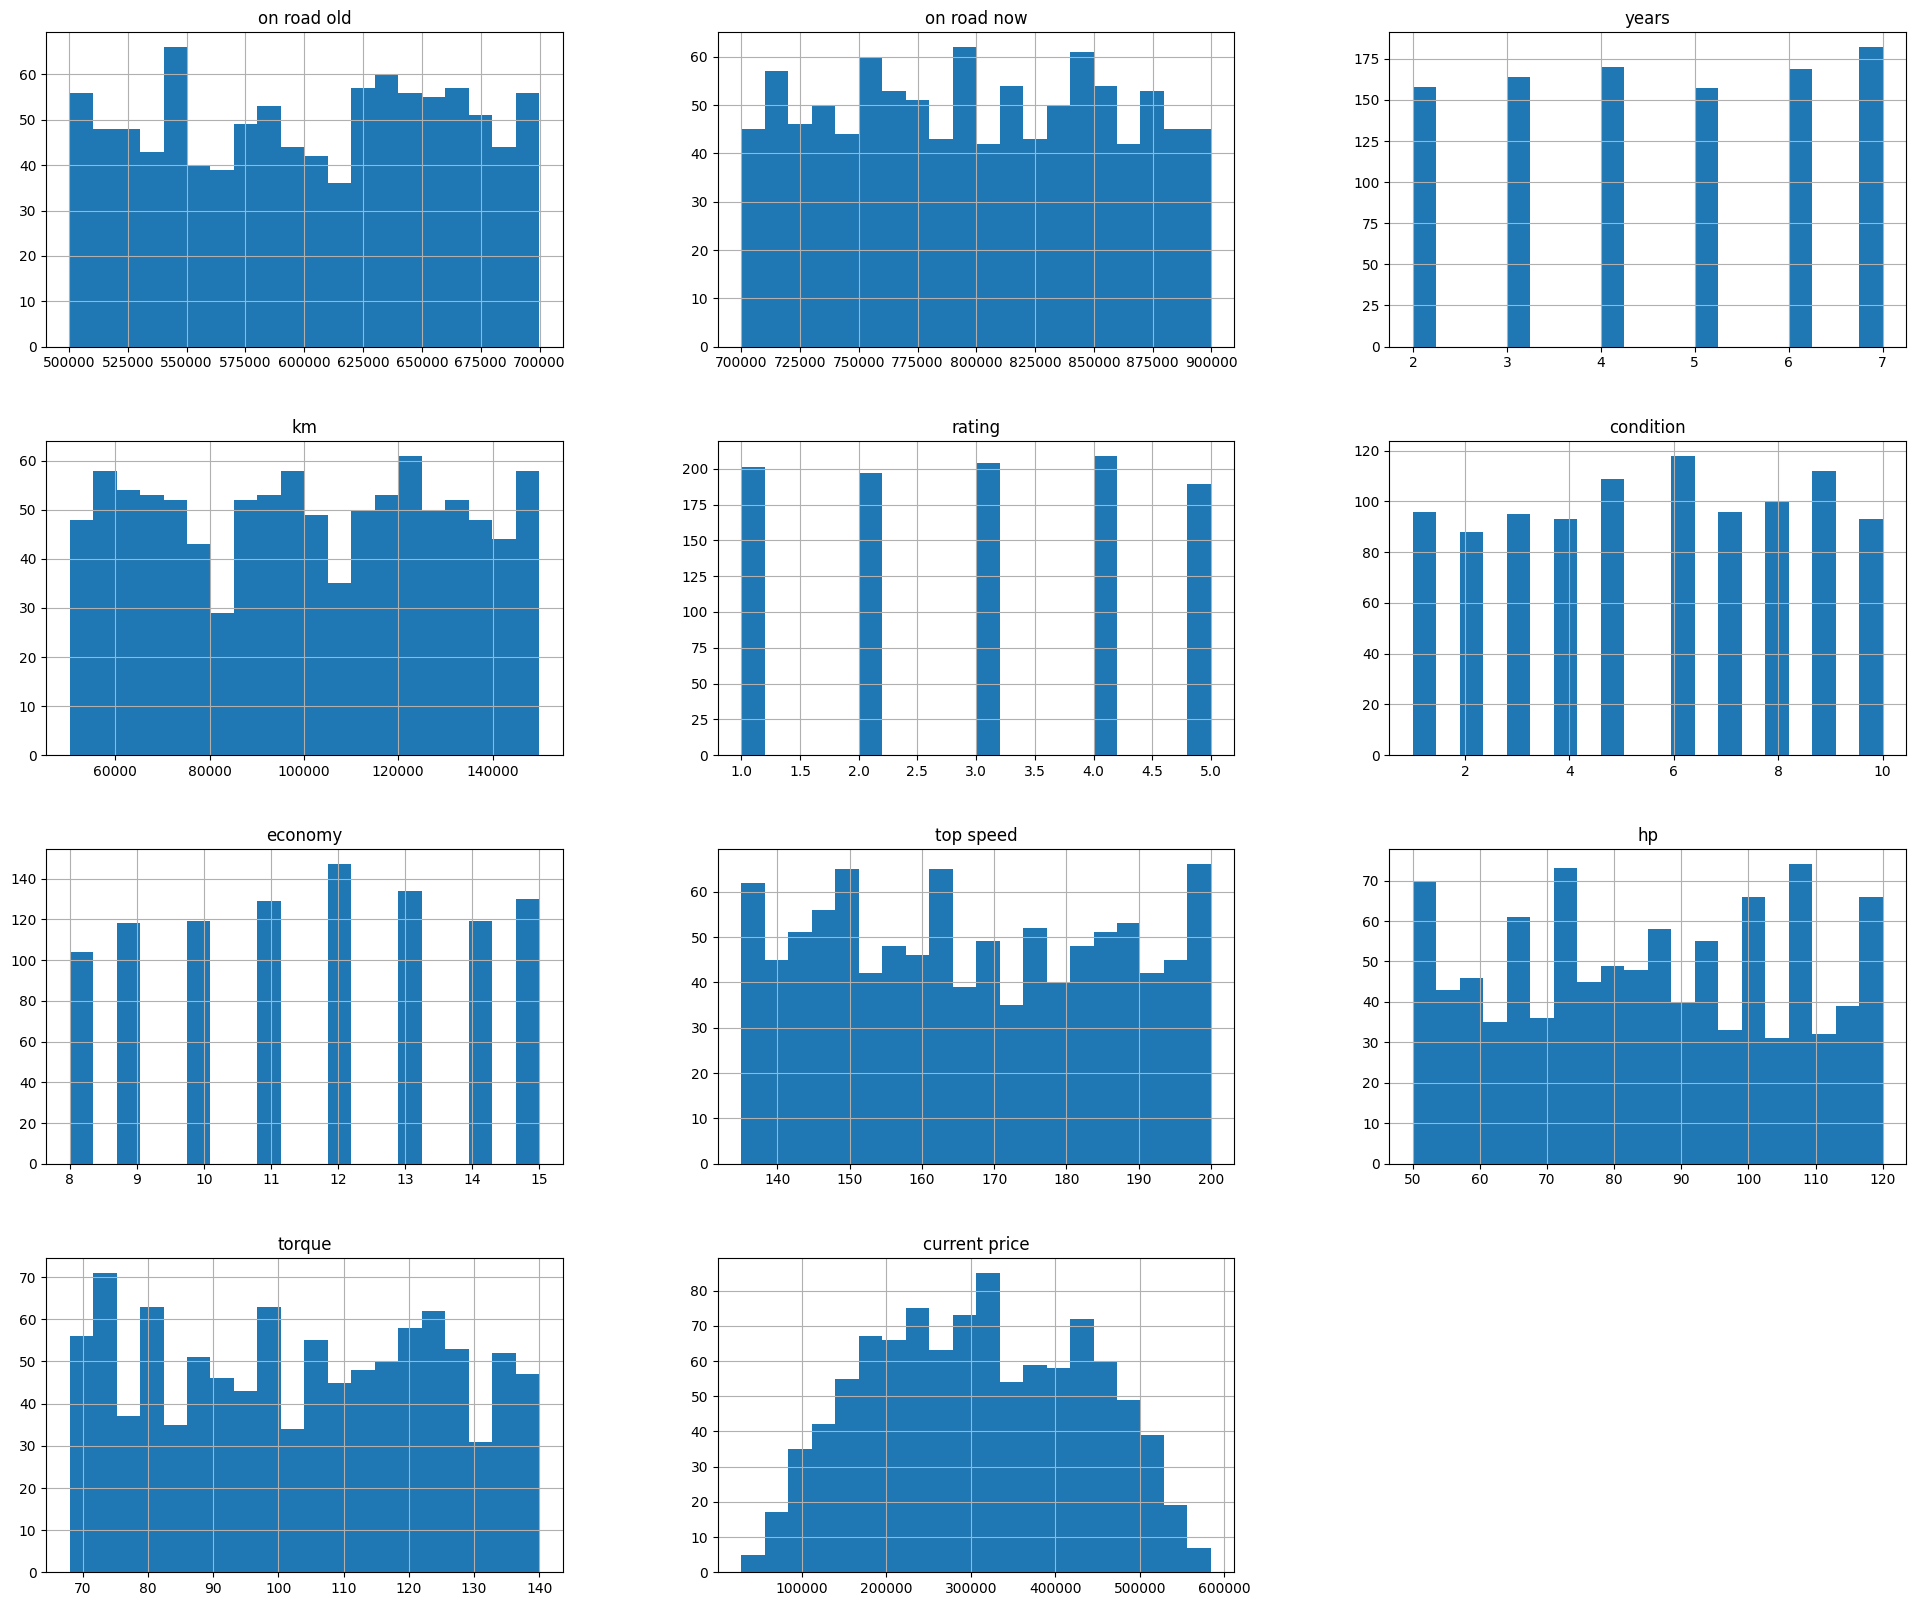

In [330]:
# Understand the distribution of the dataset - Histogram
dataset[dataset.columns[1:]].hist(bins=20, figsize=(24,20))
plt.show()

**Statistical Tests:** 
There are several statistical tests that can be used to formally test whether a distribution is normal. One common test is the Shapiro-Wilk test. A p-value less than 0.05 typically indicates a non-normal distribution.

In [331]:
# Initialize an empty list to store the results
shapiro_results = []

# Perform the Shapiro-Wilk test for each column and store the results in the list
for column in dataset.columns[1:]:
    statistic, p_value = stats.shapiro(dataset[column])
    if p_value < 0.05:
        dist_type = "Non-normal"
    else:
        dist_type = "Normal"
    shapiro_results.append([column, round(statistic, 3), p_value, dist_type])

# Print the results in a table-like structure
print(tabulate(shapiro_results, headers=['Column', 'Statistic', 'p-value', 'Distribution Type'], tablefmt='pretty'))

+---------------+-----------+------------------------+-------------------+
|    Column     | Statistic |        p-value         | Distribution Type |
+---------------+-----------+------------------------+-------------------+
|  on road old  |   0.95    |  7.82073130261531e-18  |    Non-normal     |
|  on road now  |   0.957   | 1.2719343197502113e-16 |    Non-normal     |
|     years     |   0.904   | 1.4534285903925615e-24 |    Non-normal     |
|      km       |   0.951   | 1.0978541267512021e-17 |    Non-normal     |
|    rating     |   0.89    | 4.5827222611294374e-26 |    Non-normal     |
|   condition   |   0.94    | 9.571164049948447e-20  |    Non-normal     |
|    economy    |   0.933   | 8.069600855439409e-21  |    Non-normal     |
|   top speed   |   0.95    | 7.276436533388067e-18  |    Non-normal     |
|      hp       |   0.956   | 1.1610182669830168e-16 |    Non-normal     |
|    torque     |   0.952   | 1.5351085814277555e-17 |    Non-normal     |
| current price |   0.977

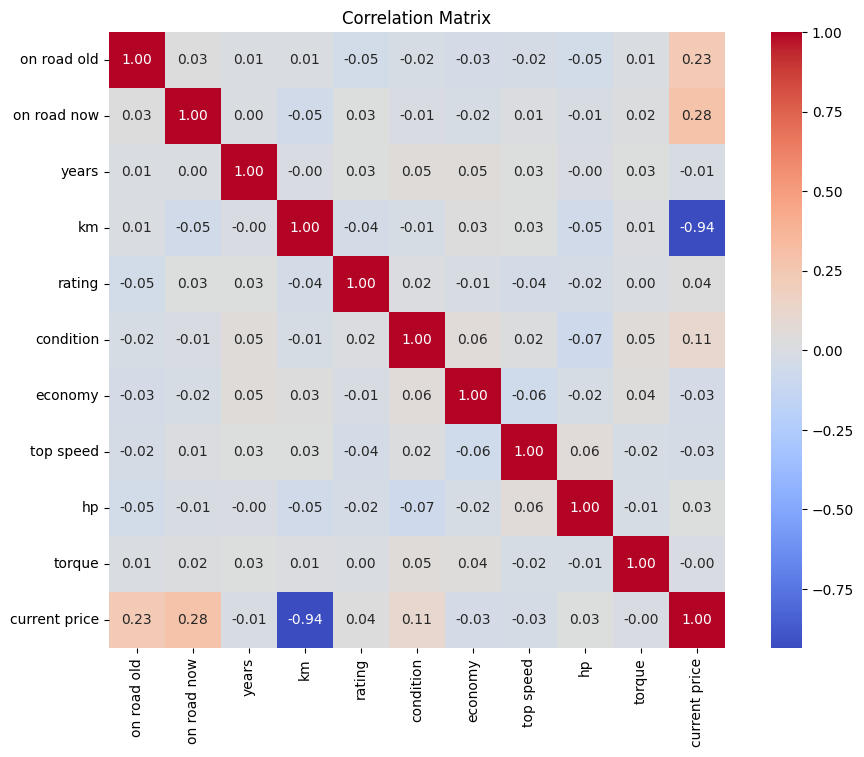

In [332]:
corr_matrix = dataset[dataset.columns[1:]].corr()
# Assuming corr_matrix is your correlation matrix
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()

In [333]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)

X = dataset[dataset.columns[3:-1]]
y = dataset['current price'].astype(int)

fit = bestfeatures.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)

featureScores.columns = ['Specs','Score']  #naming the dataframe columns

useful_best_features = featureScores.nlargest(7,'Score')

specs_parameters = useful_best_features['Specs'].tolist()

specs_parameters.append('current price')

print(specs_parameters)

print(useful_best_features)  #print 7 best features

['km', 'hp', 'torque', 'top speed', 'condition', 'rating', 'years', 'current price']
       Specs         Score
1         km  8.464701e+06
6         hp  4.973055e+03
7     torque  4.275897e+03
5  top speed  2.225267e+03
3  condition  1.424810e+03
2     rating  6.579170e+02
0      years  6.463010e+02


c:\Users\Damilare\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=8. All the features will be returned.
  warnings.warn(


In [334]:
dataset_ref = dataset[specs_parameters]
dataset_ref.head(5)

,km,hp,torque,top speed,condition,rating,years,current price
0,78945,73,123,177,2,1,3,351318.0
1,117220,74,95,148,9,5,6,285001.5
2,132538,53,97,181,8,2,2,215386.0
3,101065,54,116,197,3,4,4,244295.5
4,61559,53,105,160,9,3,6,531114.5


In [335]:
# Convert the dataset to tensor...
tensor_data = tf.constant(dataset_ref)

# Convert all the dataset to float32
tensor_data = tf.cast(tensor_data, dtype=tf.float32)

# View the head of the dataset
tensor_data[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[7.894500e+04, 7.300000e+01, 1.230000e+02, 1.770000e+02,
        2.000000e+00, 1.000000e+00, 3.000000e+00, 3.513180e+05],
       [1.172200e+05, 7.400000e+01, 9.500000e+01, 1.480000e+02,
        9.000000e+00, 5.000000e+00, 6.000000e+00, 2.850015e+05],
       [1.325380e+05, 5.300000e+01, 9.700000e+01, 1.810000e+02,
        8.000000e+00, 2.000000e+00, 2.000000e+00, 2.153860e+05],
       [1.010650e+05, 5.400000e+01, 1.160000e+02, 1.970000e+02,
        3.000000e+00, 4.000000e+00, 4.000000e+00, 2.442955e+05],
       [6.155900e+04, 5.300000e+01, 1.050000e+02, 1.600000e+02,
        9.000000e+00, 3.000000e+00, 6.000000e+00, 5.311145e+05]],
      dtype=float32)>

In [336]:
# Let's randomize the dataset
tensor_data = tf.random.shuffle(tensor_data)

tensor_data[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[1.402960e+05, 9.400000e+01, 8.500000e+01, 2.000000e+02,
        5.000000e+00, 4.000000e+00, 4.000000e+00, 6.273700e+04],
       [1.222120e+05, 7.300000e+01, 1.060000e+02, 1.430000e+02,
        8.000000e+00, 3.000000e+00, 2.000000e+00, 2.736745e+05],
       [1.244990e+05, 5.400000e+01, 9.500000e+01, 1.810000e+02,
        1.000000e+01, 1.000000e+00, 2.000000e+00, 2.081895e+05],
       [1.310760e+05, 5.100000e+01, 1.280000e+02, 1.360000e+02,
        6.000000e+00, 4.000000e+00, 7.000000e+00, 1.071475e+05],
       [1.198620e+05, 8.900000e+01, 8.800000e+01, 1.430000e+02,
        9.000000e+00, 4.000000e+00, 6.000000e+00, 2.895705e+05]],
      dtype=float32)>

In [337]:
dataset_size = len(tensor_data)

print(f"Dataset size: {dataset_size}")

train_size = int(0.8 * dataset_size)
print(f"Train dataset size: {train_size}")

val_size = int(0.1 * dataset_size)
print(f"Validation dataset size: {val_size}")

test_size = int(0.1 * dataset_size)
print(f"Test dataset size: {test_size}")

Dataset size: 1000
Train dataset size: 800
Validation dataset size: 100
Test dataset size: 100


In [338]:
# Dataset separation into (dependent) and independent variables - target variable

# Dependent variable
X = tensor_data[:, :8]

print(X[:3])

# Target variable
y = tf.expand_dims(tensor_data[:, -1], axis=-1)

print(y[:3])

tf.Tensor(
[[1.402960e+05 9.400000e+01 8.500000e+01 2.000000e+02 5.000000e+00
  4.000000e+00 4.000000e+00 6.273700e+04]
 [1.222120e+05 7.300000e+01 1.060000e+02 1.430000e+02 8.000000e+00
  3.000000e+00 2.000000e+00 2.736745e+05]
 [1.244990e+05 5.400000e+01 9.500000e+01 1.810000e+02 1.000000e+01
  1.000000e+00 2.000000e+00 2.081895e+05]], shape=(3, 8), dtype=float32)
tf.Tensor(
[[ 62737. ]
 [273674.5]
 [208189.5]], shape=(3, 1), dtype=float32)


In [339]:
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[:val_size]
y_val = y[:val_size]

X_test = X[:test_size]
y_test = y[:test_size]

In [340]:
# Convert the tensor to a tf.data.Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle the dataset
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [341]:
for x, y in train_dataset:
    print(x[:5],y[:5])
    break

tf.Tensor(
[[1.198620e+05 8.900000e+01 8.800000e+01 1.430000e+02 9.000000e+00
  4.000000e+00 6.000000e+00 2.895705e+05]
 [1.402960e+05 9.400000e+01 8.500000e+01 2.000000e+02 5.000000e+00
  4.000000e+00 4.000000e+00 6.273700e+04]
 [5.860400e+04 1.170000e+02 1.050000e+02 1.530000e+02 4.000000e+00
  3.000000e+00 6.000000e+00 4.002570e+05]
 [1.244990e+05 5.400000e+01 9.500000e+01 1.810000e+02 1.000000e+01
  1.000000e+00 2.000000e+00 2.081895e+05]
 [9.577100e+04 8.800000e+01 1.150000e+02 1.360000e+02 9.000000e+00
  1.000000e+00 4.000000e+00 3.407600e+05]], shape=(5, 8), dtype=float32) tf.Tensor(
[[289570.5]
 [ 62737. ]
 [400257. ]
 [208189.5]
 [340760. ]], shape=(5, 1), dtype=float32)


In [342]:
for x, y in val_dataset:
    print(x[:5], y[:5])
    break

tf.Tensor(
[[7.501100e+04 6.500000e+01 9.900000e+01 1.870000e+02 1.000000e+00
  1.000000e+00 6.000000e+00 4.011205e+05]
 [1.310760e+05 5.100000e+01 1.280000e+02 1.360000e+02 6.000000e+00
  4.000000e+00 7.000000e+00 1.071475e+05]
 [1.404780e+05 1.120000e+02 1.280000e+02 1.840000e+02 5.000000e+00
  4.000000e+00 2.000000e+00 7.439800e+04]
 [1.244990e+05 5.400000e+01 9.500000e+01 1.810000e+02 1.000000e+01
  1.000000e+00 2.000000e+00 2.081895e+05]
 [1.303930e+05 7.700000e+01 1.370000e+02 1.950000e+02 6.000000e+00
  3.000000e+00 4.000000e+00 2.217810e+05]], shape=(5, 8), dtype=float32) tf.Tensor(
[[401120.5]
 [107147.5]
 [ 74398. ]
 [208189.5]
 [221781. ]], shape=(5, 1), dtype=float32)


In [343]:
for x, y in test_dataset:
    print(x[:5], y[:5])
    break

tf.Tensor(
[[1.402960e+05 9.400000e+01 8.500000e+01 2.000000e+02 5.000000e+00
  4.000000e+00 4.000000e+00 6.273700e+04]
 [1.310760e+05 5.100000e+01 1.280000e+02 1.360000e+02 6.000000e+00
  4.000000e+00 7.000000e+00 1.071475e+05]
 [7.501100e+04 6.500000e+01 9.900000e+01 1.870000e+02 1.000000e+00
  1.000000e+00 6.000000e+00 4.011205e+05]
 [1.222120e+05 7.300000e+01 1.060000e+02 1.430000e+02 8.000000e+00
  3.000000e+00 2.000000e+00 2.736745e+05]
 [1.244990e+05 5.400000e+01 9.500000e+01 1.810000e+02 1.000000e+01
  1.000000e+00 2.000000e+00 2.081895e+05]], shape=(5, 8), dtype=float32) tf.Tensor(
[[ 62737. ]
 [107147.5]
 [401120.5]
 [273674.5]
 [208189.5]], shape=(5, 1), dtype=float32)


In [344]:
# Let's normalize the dataset.
normalizer = Normalization(axis=-1)

normalizer.adapt(X_train)

normalizer(X_train)[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[ 1.3812723 ,  0.48406824, -0.8469127 ,  1.7178336 , -0.1989846 ,
         0.7032571 , -0.30838916, -1.9640229 ],
       [ 0.76605195, -0.5383543 ,  0.14868887, -1.2231545 ,  0.86226654,
        -0.01618718, -1.4585582 , -0.29699036],
       [ 0.84385604, -1.4634032 , -0.3728167 ,  0.73750424,  1.5697674 ,
        -1.4550757 , -1.4585582 , -0.81451625],
       [ 1.0676066 , -1.6094636 ,  1.1917    , -1.5843285 ,  0.15476578,
         0.7032571 ,  1.4168645 , -1.6130481 ],
       [ 0.6861046 ,  0.2406343 , -0.7046839 , -1.2231545 ,  1.2160169 ,
         0.7032571 ,  0.84177995, -0.17136477]], dtype=float32)>

#### **Build your model:** Model Architecture

In [345]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (8, )),
    normalizer,
    Dense(128, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 8)                 17        
 tion)                                                           
                                                                 
 dense_8 (Dense)             (None, 128)               1152      
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 34322 (134.07 KB)
Trainable params: 34305 (134.00 KB)
Non-trainable params: 17 (72.00 Byte)
______________

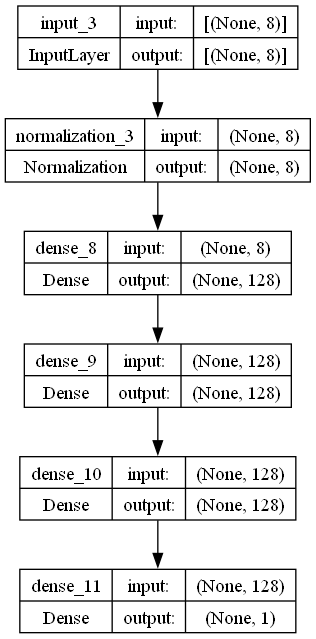

In [346]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

In [347]:
# Compile the model...
model.compile(optimizer=Adam(learning_rate = 0.1), loss=MeanAbsoluteError(), metrics=RootMeanSquaredError())

In [348]:
# Let's train the model.
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=0)

In [359]:
loss_function = history.history['loss'][:5]
print(f"Loss records: {loss_function}")
rmse_eval_metric = history.history['root_mean_squared_error'][:5]
print(f"RMSE records: {rmse_eval_metric}")

Loss records: [152634.734375, 39436.44921875, 27023.0, 24841.740234375, 24158.384765625]
RMSE records: [199968.21875, 50378.84765625, 34027.15625, 30996.806640625, 30333.912109375]


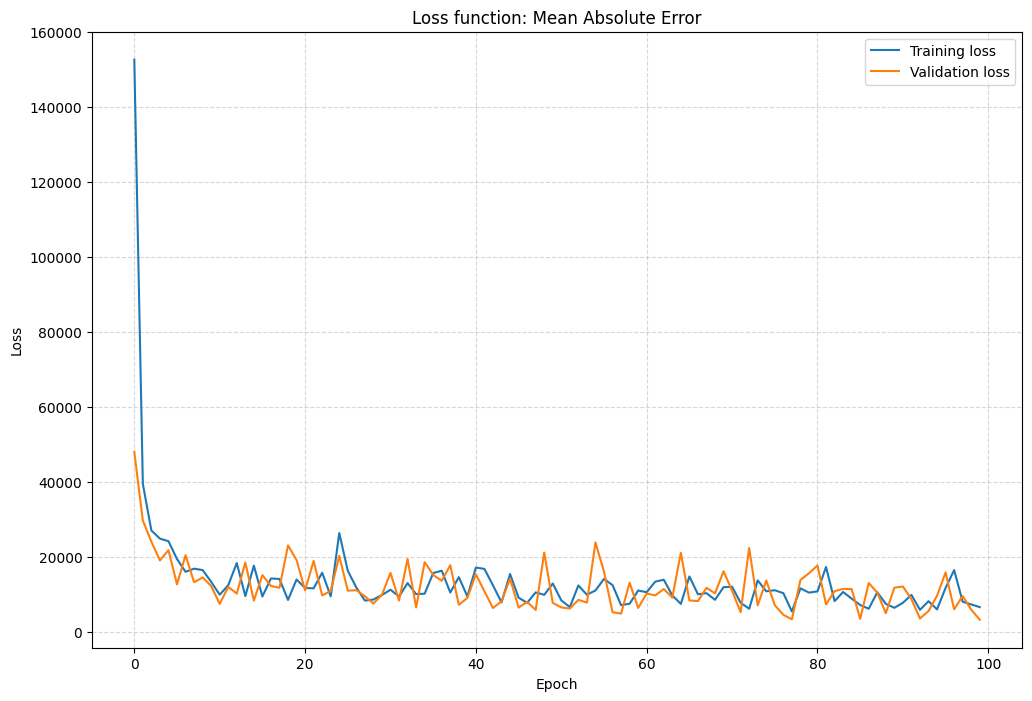

In [361]:
plt.figure(figsize=(12,8))
plt.grid(True, linestyle="--", alpha=0.5)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss function: Mean Absolute Error")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training loss", "Validation loss"])
plt.show()

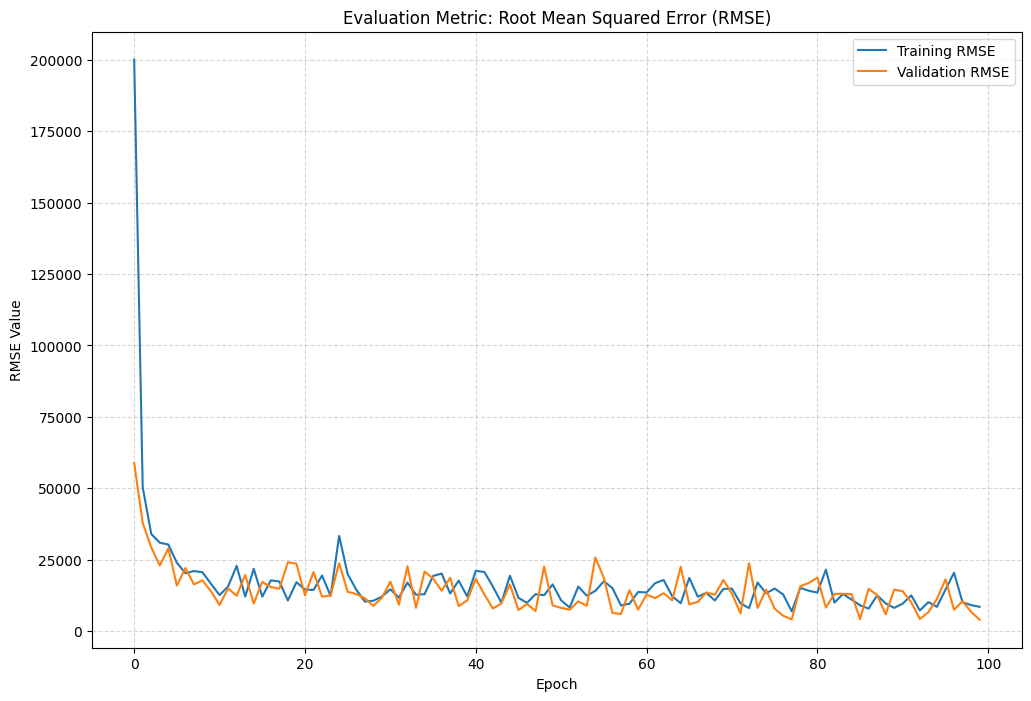

In [362]:
plt.figure(figsize=(12,8))
plt.grid(True, linestyle="--", alpha=0.5)
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("Evaluation Metric: Root Mean Squared Error (RMSE)")
plt.ylabel("RMSE Value")
plt.xlabel("Epoch")
plt.legend(["Training RMSE", "Validation RMSE"])
plt.show()

In [352]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 3200.2119 - root_mean_squared_error: 4041.5942


[3200.2119140625, 4041.59423828125]

In [353]:
y_pred = list(model.predict(X_test)[:,0])
y_pred[:5]

4/4 [==============================] - 0s 2ms/step


[65429.766, 271154.97, 198618.77, 110853.89, 293543.25]

In [354]:
y_true = list(y_test[:, 0].numpy())
y_true[:5]

[62737.0, 273674.5, 208189.5, 107147.5, 289570.5]

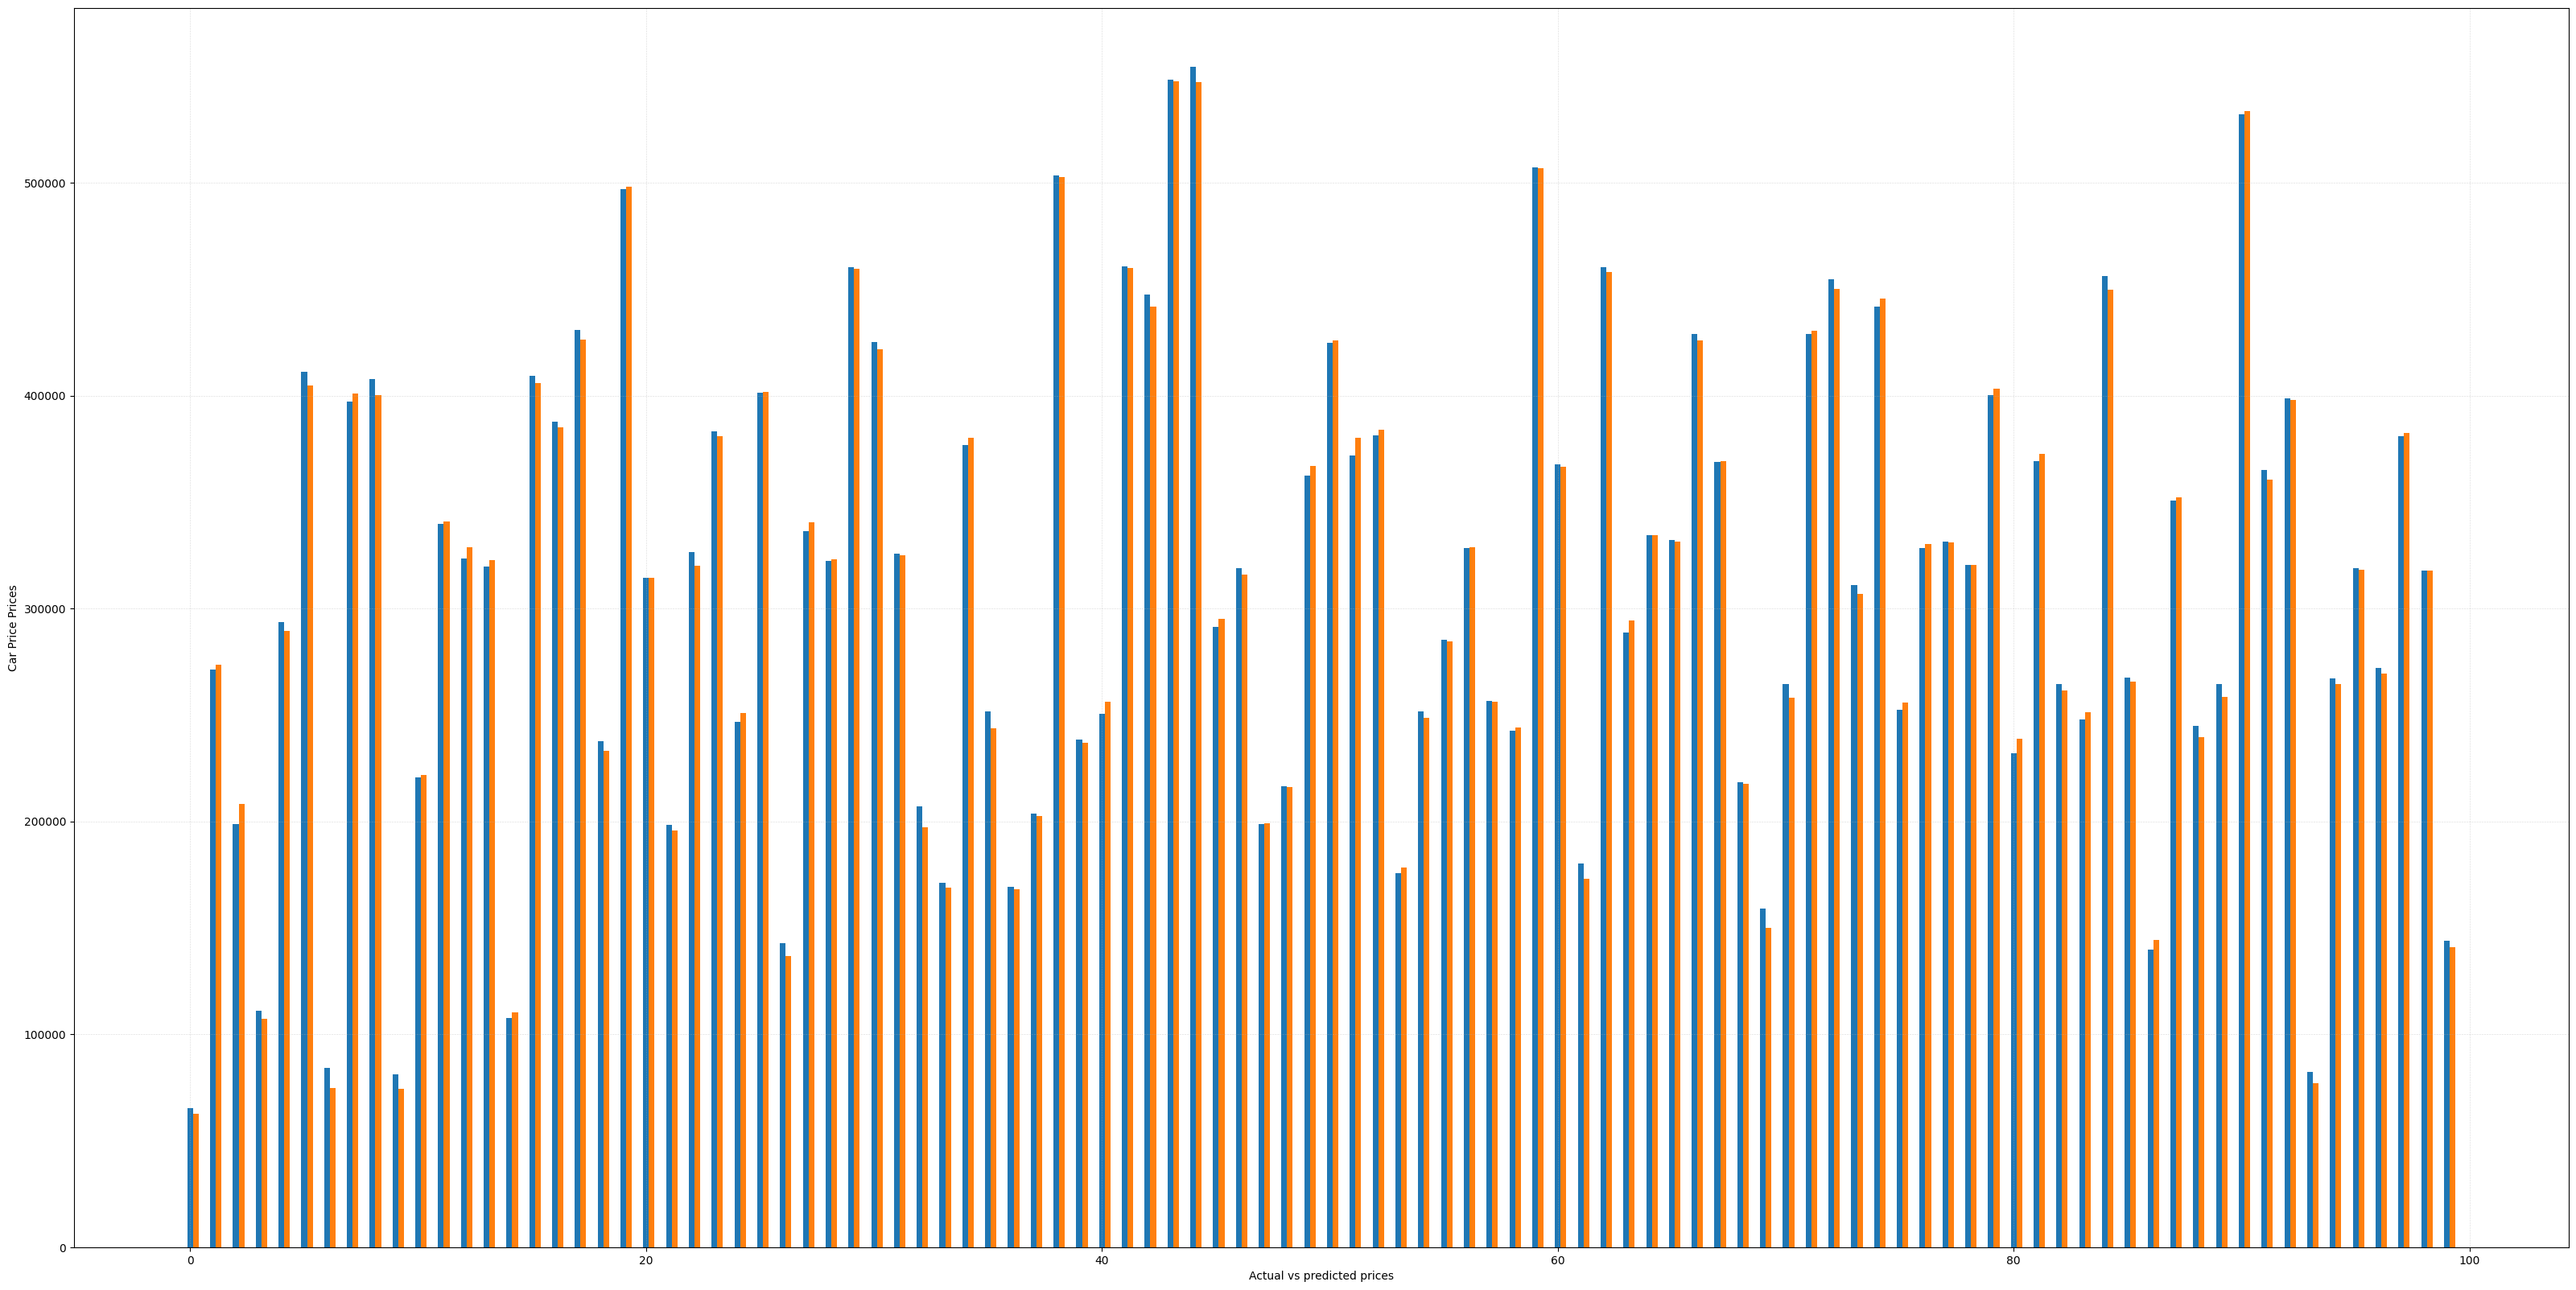

In [355]:
import numpy as np

ind = np.arange(100)
plt.figure(figsize=(40, 20))

width = 0.25

plt.grid(True, linestyle=":", alpha=0.9, linewidth=0.4)
plt.bar(ind, y_pred, width, label="Predicted car price")
plt.bar(ind + width, y_true, width, label="Actual car price")

plt.xlabel('Actual vs predicted prices')
plt.ylabel('Car Price Prices')

plt.show()